# CNN - Modelling (Binary + MOG + ResNet)

# 1. Construct `ImageDataGenerator` Instance

In [1]:
import tensorflow as tf
%matplotlib inline

print(tf.__version__)

2.4.2


In [2]:
! nvidia-smi 

/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
Thu Aug 12 09:33:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.142.00   Driver Version: 450.142.00   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%    

We center and standardize all images at per image level.

Image flips, 180 degree image rotations and image brightness is suitable for data augmentation. However, shift and zoom are not appropriate because some crackes are located at the edge of some images. Zoom and shift may remove those crackes.

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(horizontal_flip=True,
                                    vertical_flip=True,
                                    samplewise_center=True,
                                    samplewise_std_normalization=True)

datagen_test = ImageDataGenerator(samplewise_center=True,
                                   samplewise_std_normalization=True)

Then, load the data from directory:

In [4]:
from crack_utils import load_binary_dataset

SRC_BINARY = "/home/ubuntu/crack/MOG-Binary/"

x_train, x_test, y_train, y_test = load_binary_dataset(SRC_BINARY, (150, 150))

train_it = datagen_train.flow(x_train, y_train, batch_size=64, seed=100)
test_it = datagen_test.flow(x_test, y_test, batch_size=64, seed=100)

# 2. Residual Model

## 2.1 Baseline Model 

We consider Residual Module in our baseline model.

### 2.2.2 One Block Residual Model

In [5]:
from crack_utils import residual_module, classification_block, feature_reduce_block, binary_compile
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, MaxPooling2D

def one_block_Residual():
    # define model input
    visible = Input(shape=(150, 150, 1))
    # add residual module
    layer = residual_module(visible, 32)
    # add pooling layer
    layer = MaxPooling2D((3, 3))(layer)
    # add classification block
    layer = classification_block(layer, 16)
    # create model
    model = Model(inputs=visible, outputs=layer)
    return model

# create model instance
model = one_block_Residual()
binary_compile(model, 0.001, 0.9)
model.summary()

Extension horovod.torch has not been built: /home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-37m-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2021-08-12 09:33:38.492 ip-172-31-5-51:32359 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-08-12 09:33:38.514 ip-172-31-5-51:32359 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 1) 0                                            
_________________________________________________

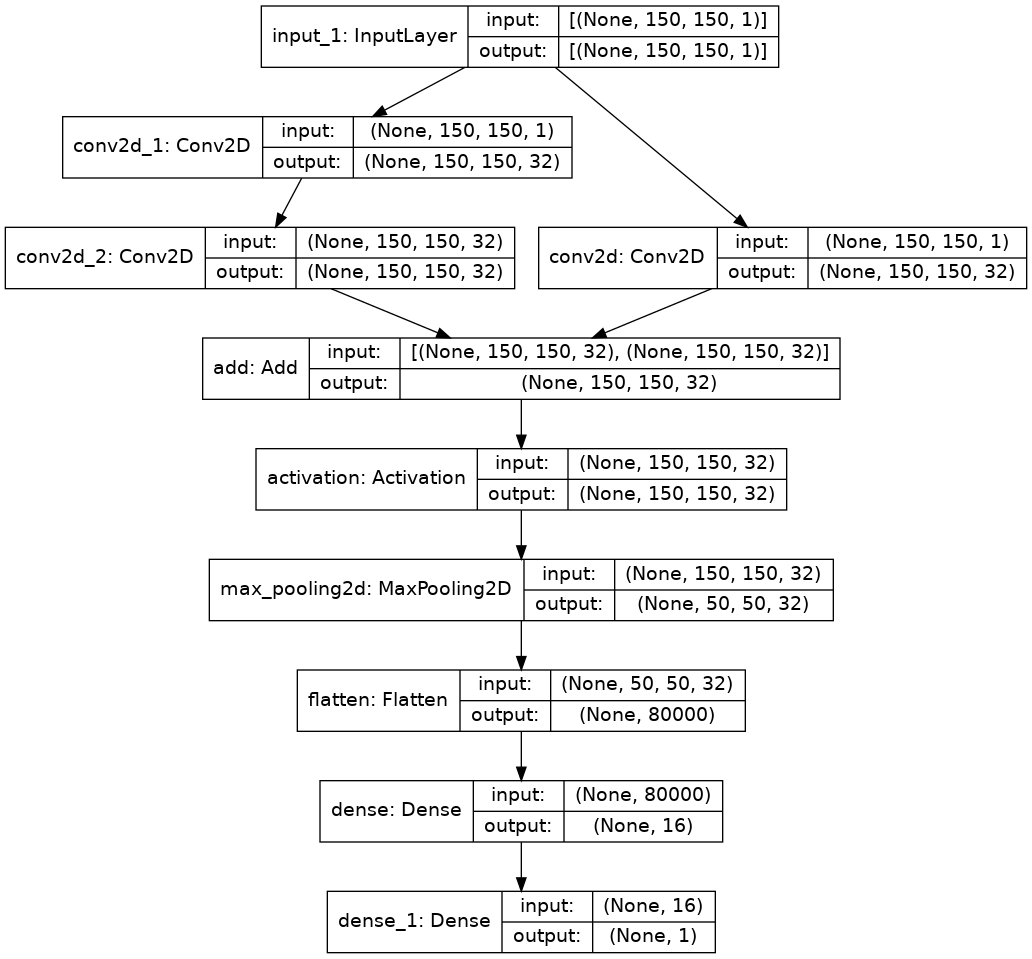

In [6]:
from tensorflow.keras.utils import plot_model

# plot model architecture
plot_model(model, show_shapes=True, to_file='model_image/Bi_MOG_Residual_1.png')

In [7]:
%%time

histories = dict()

histories["Bi_MOG_Residual_1"] = model.fit(train_it, steps_per_epoch=len(train_it),
              validation_data=test_it, validation_steps=len(test_it), epochs=30, verbose=0).history

CPU times: user 1min 56s, sys: 8.25 s, total: 2min 4s
Wall time: 3min 10s


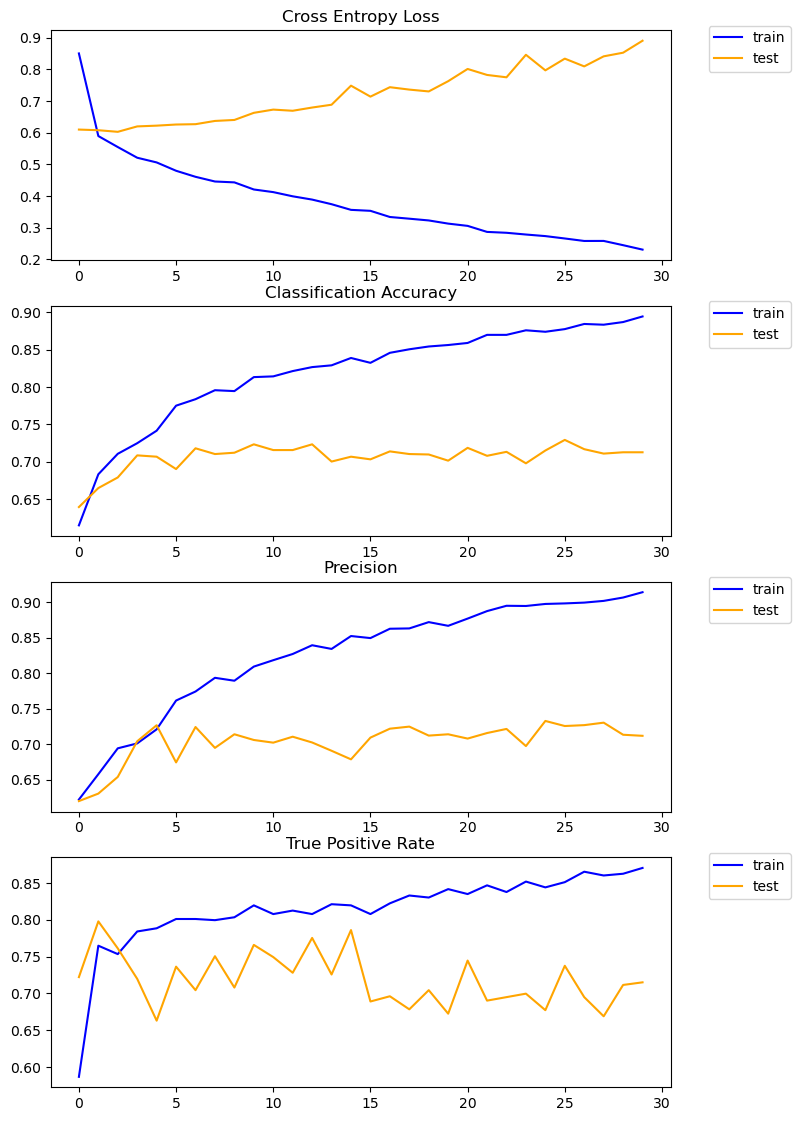

In [8]:
from crack_utils import summarize_diagnostics_binary
                                           
summarize_diagnostics_binary(histories["Bi_MOG_Residual_1"], "model_plot/Bi_MOG_Residual_1.png")

In [9]:
from crack_utils import show_result

show_result(model, test_it)

Test loss: 0.89
Test Accuracy: 0.71
Test Precision: 0.71
Test True Positive Rate: 0.72


### 2.1.2 Two Block Residual Model

In [10]:
def two_block_Residual():
    # define model input
    visible = Input(shape=(150, 150, 1))
    # add residual module
    layer = residual_module(visible, 32)
    # add pooling layer
    layer = MaxPooling2D((3, 3))(layer)
    # add pooling layer
    layer = residual_module(layer, 64)
    # add pooling layer
    layer = MaxPooling2D((3, 3))(layer)
    # add classification block
    layer = classification_block(layer, 16)
    # create model
    model = Model(inputs=visible, outputs=layer)
    return model

# create model instance
model = two_block_Residual()
binary_compile(model, 0.001, 0.9)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 150, 150, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 150, 150, 32) 9248        conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 150, 150, 32) 64          input_2[0][0]                    
____________________________________________________________________________________________

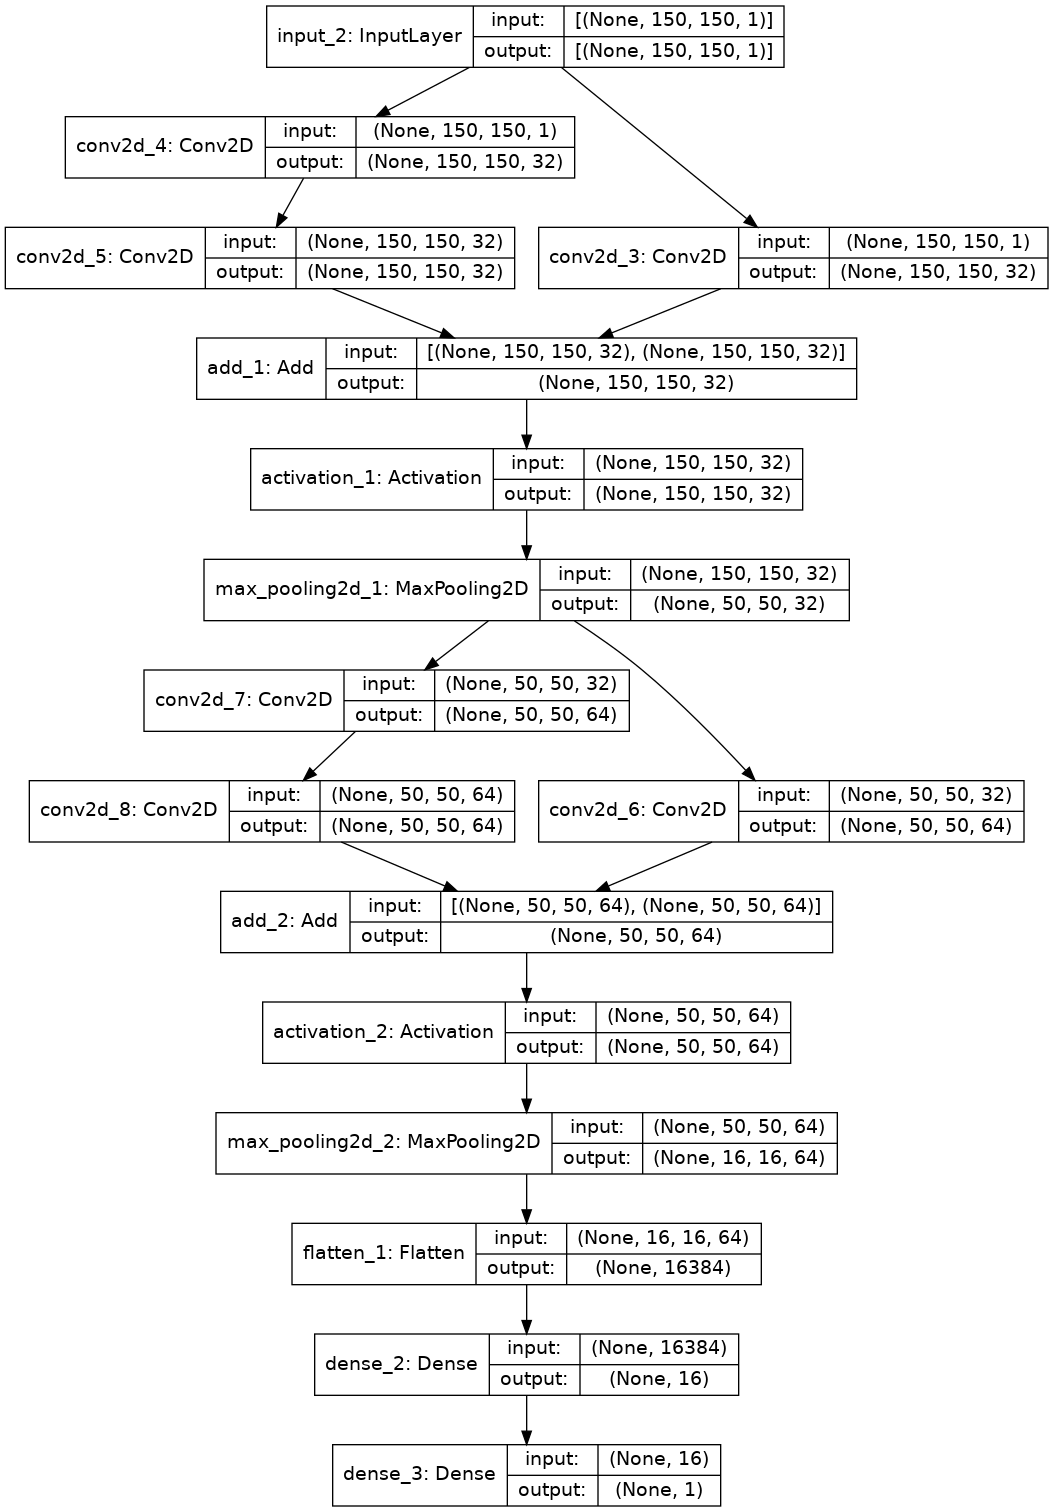

In [11]:
# plot model architecture
plot_model(model, show_shapes=True, to_file='model_image/Bi_MOG_Residual_2.png')

In [12]:
%%time

histories["Bi_MOG_Residual_2"] = model.fit(train_it, steps_per_epoch=len(train_it),
              validation_data=test_it, validation_steps=len(test_it), epochs=30, verbose=0).history

CPU times: user 2min 18s, sys: 9.86 s, total: 2min 28s
Wall time: 3min 48s


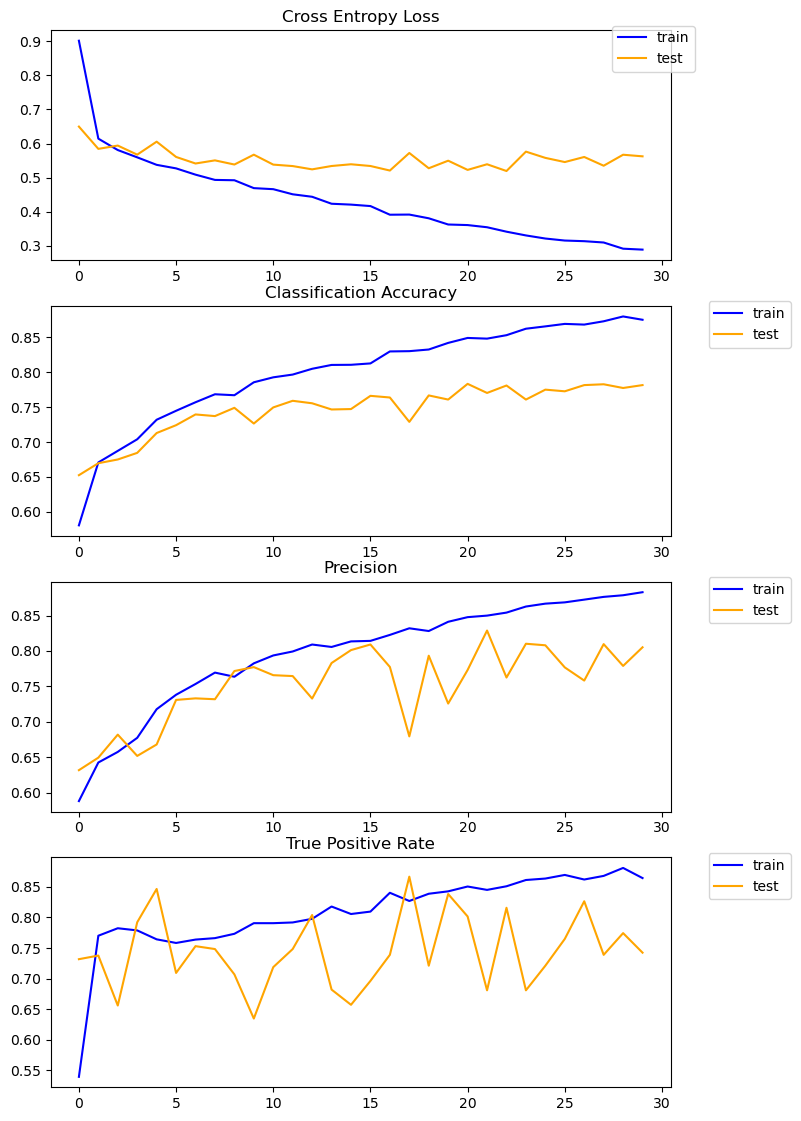

In [13]:
summarize_diagnostics_binary(histories["Bi_MOG_Residual_2"], "model_plot/Bi_MOG_Residual_2.png")

In [14]:
show_result(model, test_it)

Test loss: 0.56
Test Accuracy: 0.78
Test Precision: 0.81
Test True Positive Rate: 0.74


## 2.2 Model Improvements

### 2.2.1 Dropout Regularization



In [15]:
from tensorflow.keras.layers import Dropout

def two_block_Residual_dropout():
    # define model input
    visible = Input(shape=(150, 150, 1))
    # add residual module
    layer = residual_module(visible, 32)
    # add pooling layer
    layer = MaxPooling2D((3, 3))(layer)
    layer = Dropout(0.3)(layer)
    # add pooling layer
    layer = residual_module(layer, 64)
    # add pooling layer
    layer = MaxPooling2D((3, 3))(layer)
    layer = Dropout(0.4)(layer)
    # add classification block
    layer = classification_block(layer, 16)
    # create model
    model = Model(inputs=visible, outputs=layer)
    return model

# create model instance
model = two_block_Residual_dropout()
binary_compile(model, 0.001, 0.9)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 150, 150, 32) 320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 150, 150, 32) 9248        conv2d_10[0][0]                  
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 150, 150, 32) 64          input_3[0][0]                    
____________________________________________________________________________________________

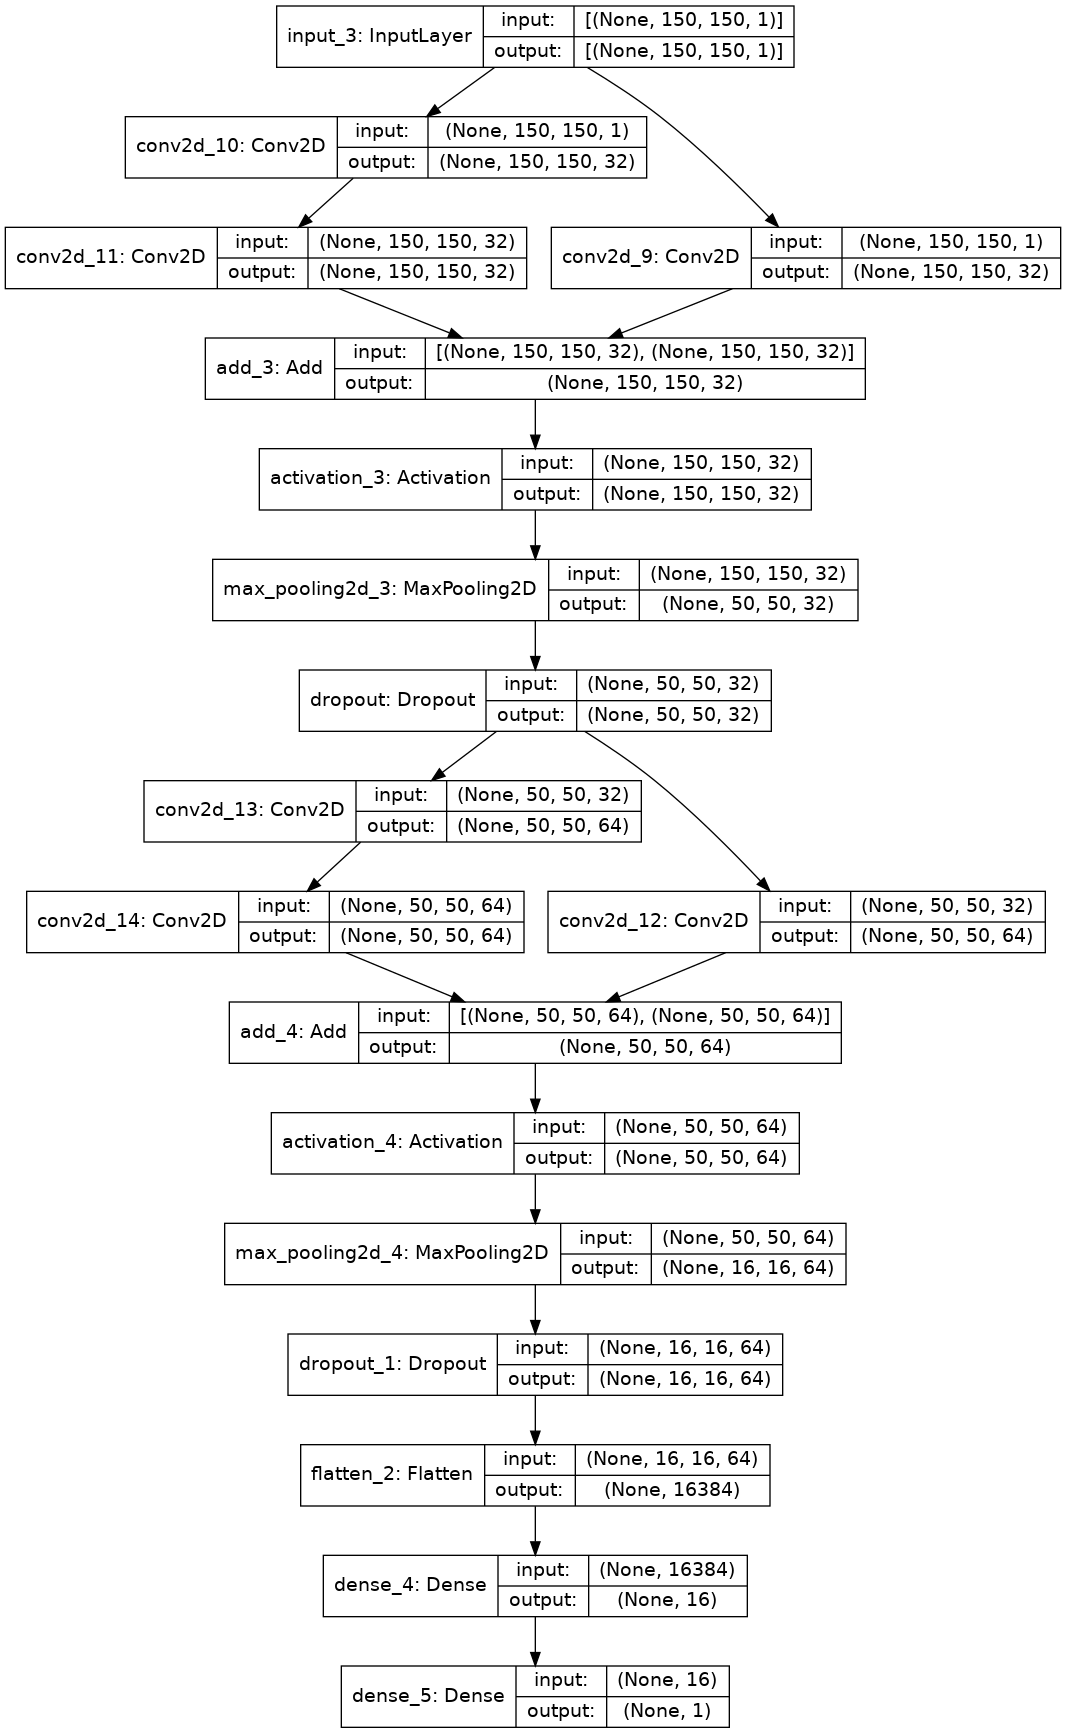

In [16]:
# plot model architecture
plot_model(model, show_shapes=True, to_file='model_image/Bi_MOG_Residual_2_dropout.png')

In [17]:
%%time

histories["Bi_MOG_Residual_2_dropout"] = model.fit(train_it, steps_per_epoch=len(train_it), 
                    validation_data=test_it, validation_steps=len(test_it), epochs=30, verbose=0).history

CPU times: user 2min 20s, sys: 11.3 s, total: 2min 31s
Wall time: 3min 52s


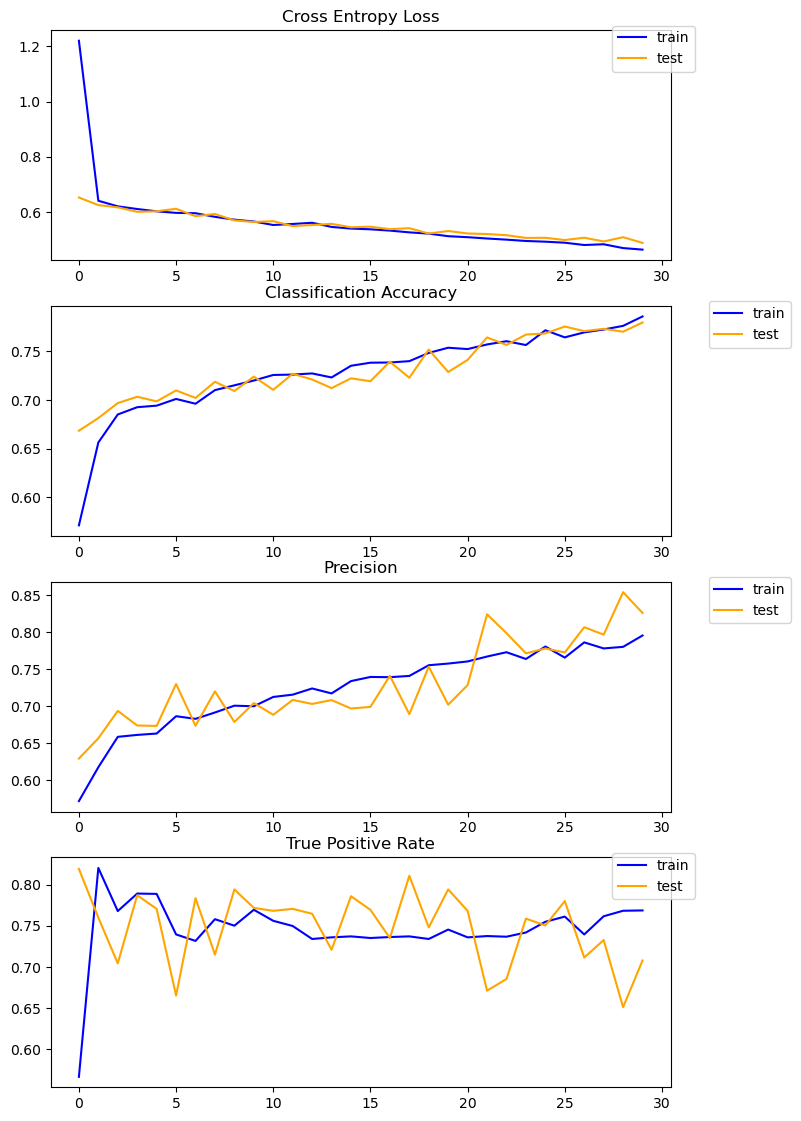

In [18]:
summarize_diagnostics_binary(histories["Bi_MOG_Residual_2_dropout"], "model_plot/Bi_MOG_Residual_2_dropout.png")

In [19]:
show_result(model, test_it)

Test loss: 0.49
Test Accuracy: 0.78
Test Precision: 0.83
Test True Positive Rate: 0.71


### 2.2.1 Weight Decay + Dropout

In [20]:
from tensorflow.keras.regularizers import l2

def two_block_Residual_dropout_decay():
    # define model input
    visible = Input(shape=(150, 150, 1))
    # add residual module
    layer = residual_module(visible, 32, decay=l2(0.01))
    # add pooling layer
    layer = MaxPooling2D((3, 3))(layer)
    layer = Dropout(0.3)(layer)
    # add pooling layer
    layer = residual_module(layer, 64, decay=l2(0.01))
    # add pooling layer
    layer = MaxPooling2D((3, 3))(layer)
    layer = Dropout(0.4)(layer)
    # add classification block
    layer = classification_block(layer, 16, decay=l2(0.01))
    # create model
    model = Model(inputs=visible, outputs=layer)
    return model

# create model instance
model = two_block_Residual_dropout_decay()
binary_compile(model, 0.001, 0.9)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 150, 150, 32) 320         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 150, 150, 32) 9248        conv2d_16[0][0]                  
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 150, 150, 32) 64          input_4[0][0]                    
____________________________________________________________________________________________

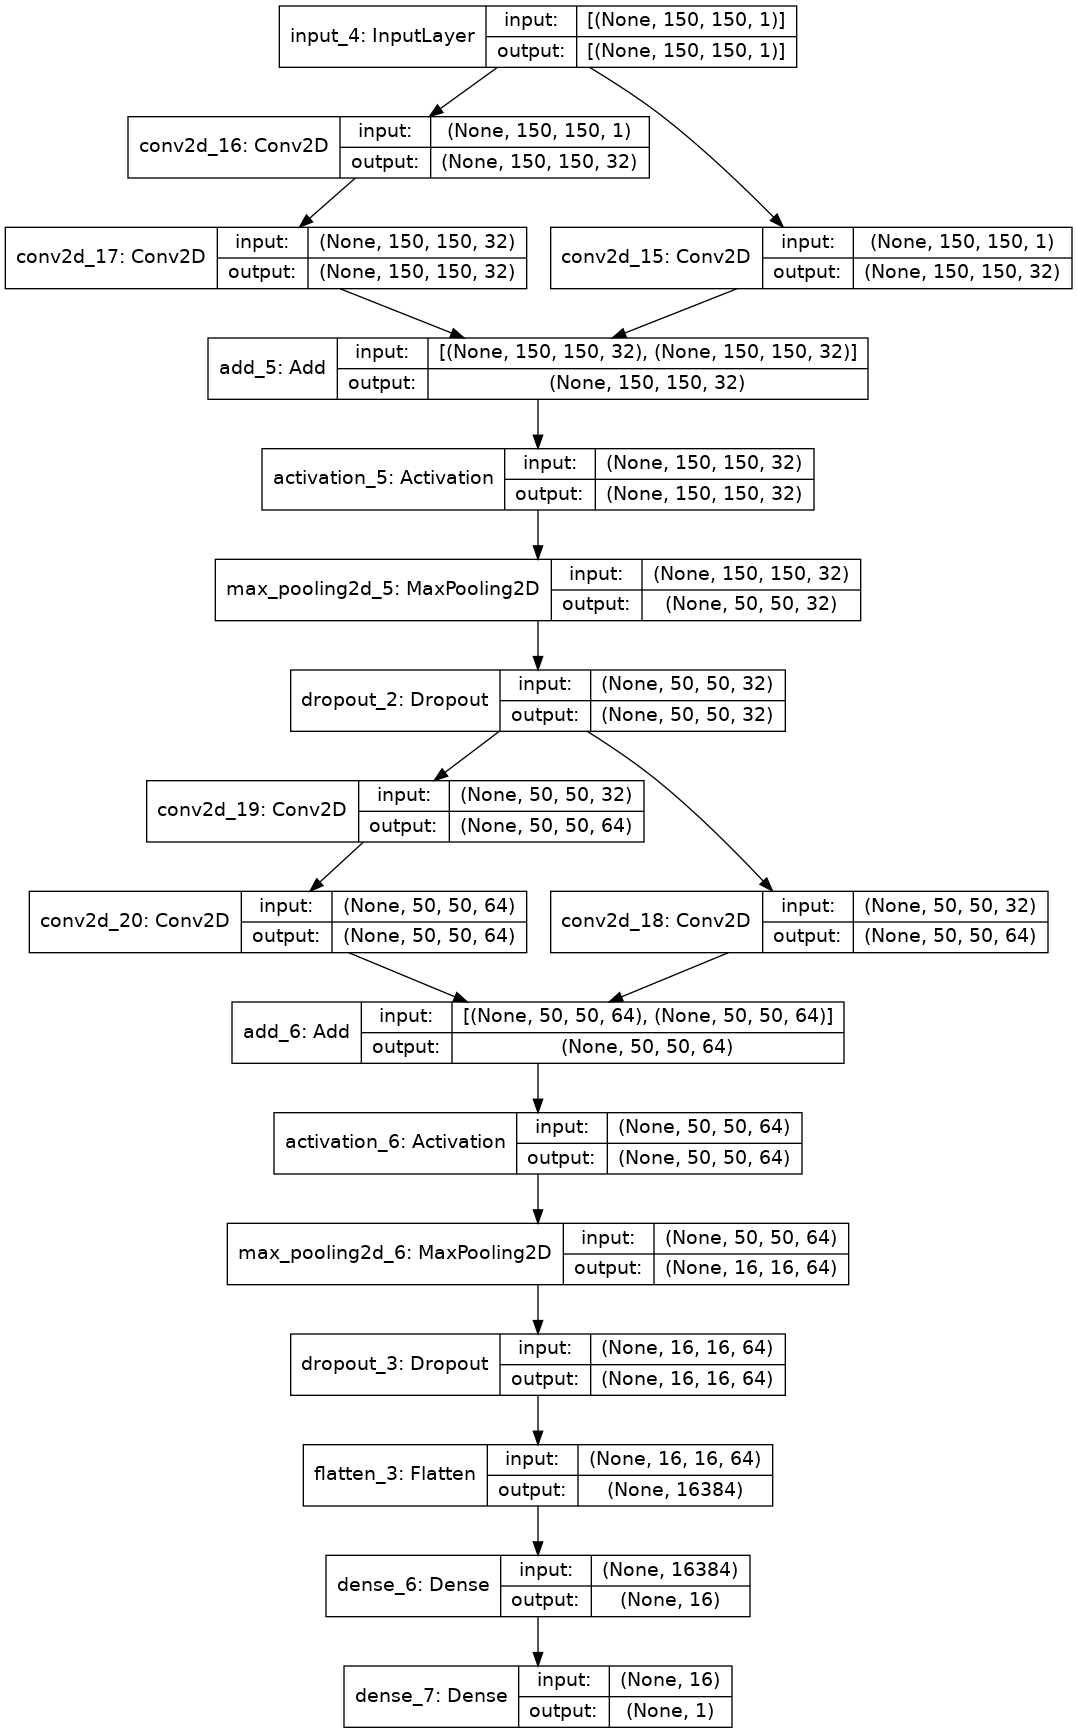

In [21]:
# plot model architecture
plot_model(model, show_shapes=True, to_file='model_image/Bi_MOG_Residual_2_dropout_decay.png')

In [22]:
%%time

histories["Bi_MOG_Residual_2_dropout_decay"] = model.fit(train_it, steps_per_epoch=len(train_it), 
                          validation_data=test_it, validation_steps=len(test_it), epochs=30, verbose=0).history

CPU times: user 2min 25s, sys: 9.97 s, total: 2min 35s
Wall time: 3min 53s


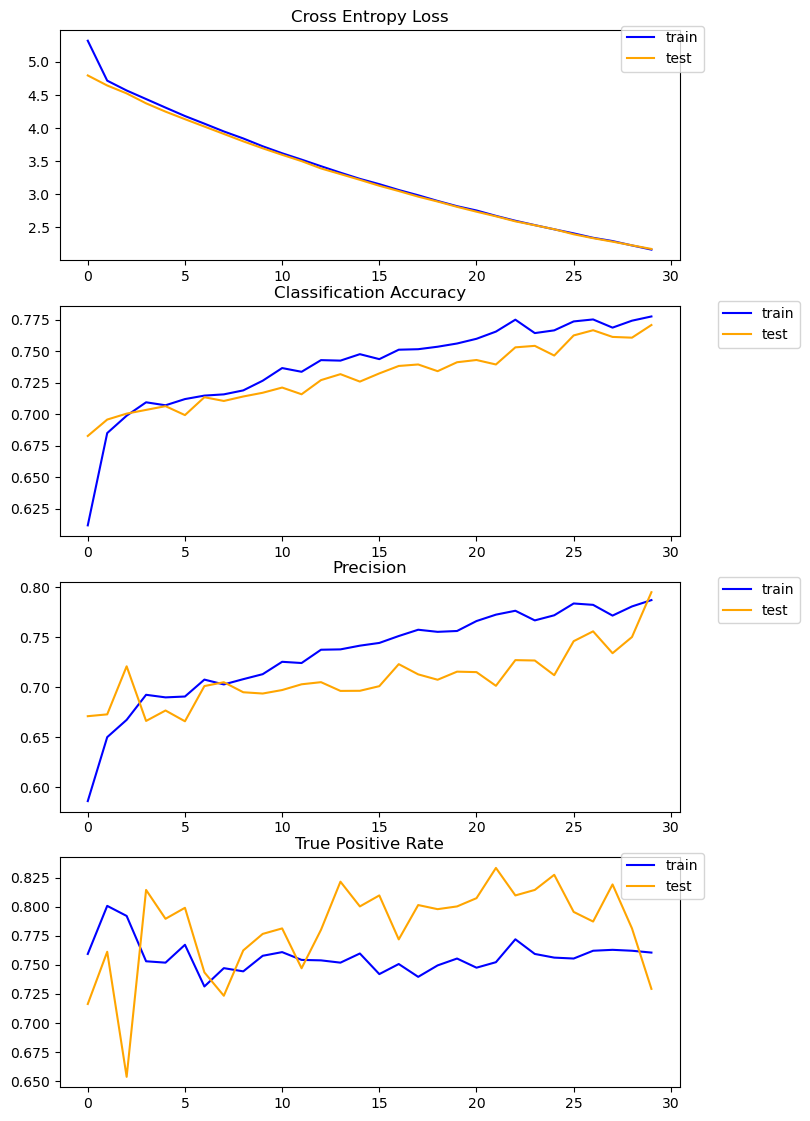

In [23]:
summarize_diagnostics_binary(histories["Bi_MOG_Residual_2_dropout_decay"], "model_plot/Bi_MOG_Residual_2_dropout_decay.png")

In [24]:
show_result(model, test_it)

Test loss: 2.18
Test Accuracy: 0.77
Test Precision: 0.80
Test True Positive Rate: 0.73


# 3. Summary

30th epoch result:

In [25]:
from crack_utils import get_percentile_result

result_30 = get_percentile_result(histories, 30)
result_30.round(2)

,Bi_MOG_Residual_1,Bi_MOG_Residual_2,Bi_MOG_Residual_2_dropout,Bi_MOG_Residual_2_dropout_decay
Loss,0.89,0.56,0.49,2.18
Accuracy,0.71,0.78,0.78,0.77
Precision,0.71,0.81,0.83,0.80
TPR,0.72,0.74,0.71,0.73


21-30 epochs (Average):

In [26]:
from crack_utils import get_avg_result

avg_result = get_avg_result(histories, start_epoch=21)
avg_result.round(2)

,Bi_MOG_Residual_1,Bi_MOG_Residual_2,Bi_MOG_Residual_2_dropout,Bi_MOG_Residual_2_dropout_decay
Loss,0.83,0.55,0.51,2.41
Accuracy,0.71,0.78,0.77,0.76
Precision,0.72,0.79,0.80,0.74
TPR,0.70,0.75,0.72,0.80


Compare each model:

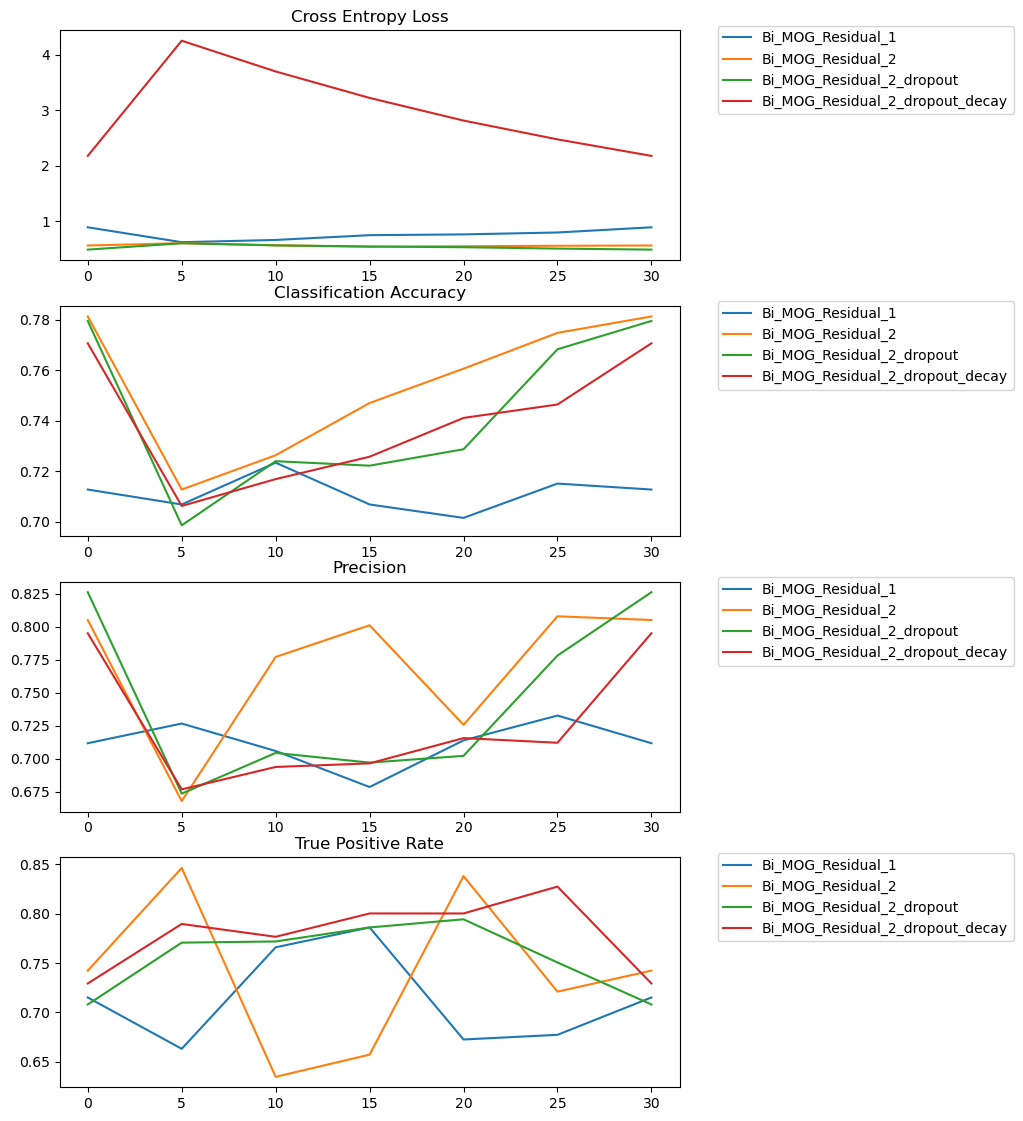

In [27]:
from crack_utils import compare_all_result

compare_all_result(histories, filename="model_plot/Compare_Bi_MOG_Residual.png", end=30, step=5)

Save epochs history:

In [28]:
from crack_utils import save_history

save_history(histories, folder="epochs_history")